# Shadow Mask Generator
Isabella Gomez

This is the implementation of the first half the Shadow Generation for Composite Image in Real-World Scenes paper (https://arxiv.org/pdf/2104.10338.pdf), which is a Shadow Mask Generator.

I will be using the DESOBA dataset which was created for this project by the authors. 

Steps:
1. Downloading dataset 
2. Creating Train/Test pairs
3. Create Ebs and Efs
4. Create CAI
5. Create Decoder
6. Build U-net model
7. Initialize loss functions and optimizers
8. Train the model
9. Show some of the output images

After this runs, I will have a saved trained model for the Shadow Predition Stage and I will have saved all the predicted shadow masks from training and testing. These will then be used in the Shadow area filling stage which will be done in another notebook.

### Setup

Initialize cuda and import libraries. In this project we will be using PyTorch.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torch.nn.init as init

import torchvision.datasets as dset
import torchvision.transforms as T
import torchvision.utils as vutils

from PIL import Image
import os
import random

import numpy as np
import matplotlib.pyplot as plt
import cv2
import math

%load_ext autoreload
%autoreload 2

# setup
device = None

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('using device:', device)

using device: cuda


### DataLoader

Make a custom dataset and load in my data.

Q: Should I eliminate the data that is not Ic, Mfos, Mbos in the transformation? i.e. only keep the relevant information for Ebs, Efs or should I just keep all of it? 

A: None yet, for now I am keeping all of it.

In [2]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.imgs = os.listdir(root_dir)
    
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.imgs[idx])
        image = Image.open(img_path).convert("RGB")  # Convert to color
        
        if self.transform is not None:
            image = self.transform(image)

        return image

transform = T.Compose([T.ToTensor()]) # can add more if necessary
    
# Batch size during training
batch_size = 1

path_train = 'DESOBA_DATASET/TrainTestVisualization/train'
path_test = 'DESOBA_DATASET/TrainTestVisualization/test_bos'
dataset = CustomDataset(path_train, transform=transform)
dataset_size = dataset.__len__()
dataset_test = CustomDataset(path_test, transform=transform)
dataset_test_size = dataset_test.__len__()

# Create the dataloaders
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size)

# size of my training set
print(dataset_size)
print(dataset_test_size)

11509
581


### Initializing Weights

In [3]:
# custom weights initialization called on encoders, to test various weight initializations

def weights_init(net, init_type='normal', gain=0.02):
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                init.normal_(m.weight.data, 0.0, gain)
            elif init_type == 'xavier':
                init.xavier_normal_(m.weight.data, gain=gain)
            elif init_type == 'kaiming':
                init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                init.orthogonal_(m.weight.data, gain=gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:
            init.normal_(m.weight.data, 1.0, gain)
            init.constant_(m.bias.data, 0.0)

    #print('initialize network with %s' % init_type)
    net.apply(init_func)

# Part 1: Creating Background and Foreground Encoders

Here I will first be getting Ic, Mfos, and Mbos (composite image, Forground Object Mask, Background Object Mask) in order to design the foreground and background encoders (Efs/Ebs respectively). These will be designed as per the paper instructions as follows:

**Ebs / Efs**
- DBlk layer, with AvgPool, 128×128×64
- DBlk layer, with AvgPool, 64×64×128
- DBlk layer, with AvgPool, 32×32×256
- DBlk layer, with AvgPool, 16×16×512

In this case DBlk means Downsampling Block. The design of these encoders is based off of the U-Net architecture.

In [4]:
# Shared downsampling block
class DBlk(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.avg_pool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.avg_pool(x)
        return x

# Foreground encoder (parameter sharing)
class EncoderFs(nn.Module):
    def __init__(self):
        super().__init__() # input is 256x256x32
        # Shared downsampling blocks
        self.down_block1 = DBlk(in_channels=32, out_channels=64)
        self.down_block2 = DBlk(in_channels=64, out_channels=128)
        self.down_block3 = DBlk(in_channels=128, out_channels=256)
        self.down_block4 = DBlk(in_channels=256, out_channels=512)
        
    def forward(self, x):
        skip1 = self.down_block1(x)
        skip2 = self.down_block2(skip1)
        skip3 = self.down_block3(skip2)
        x = self.down_block4(skip3)
        
        
        return x, skip1, skip2, skip3

In [5]:
# background encoder (no parameter sharing)
class EncoderBs(nn.Module):
    def __init__(self):
        super().__init__() # input is 256x256x32
        # downsampling block 1
        self.conv1 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU(inplace=True)
        self.avg_pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        # downsampling block 2
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU(inplace=True)
        self.avg_pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        # downsampling block 3
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.relu3 = nn.ReLU(inplace=True)
        self.avg_pool3 = nn.AvgPool2d(kernel_size=2, stride=2)
        # downsampling block 4
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.relu4 = nn.ReLU(inplace=True)
        self.avg_pool4 = nn.AvgPool2d(kernel_size=2, stride=2)
        
    def forward(self, x):
        # Save intermediate feature maps for skip connections
        skip1 = self.conv1(x)
        skip1 = self.bn1(skip1)
        x = self.relu1(skip1)
        x = self.avg_pool1(x)

        skip2 = self.conv2(x)
        skip2 = self.bn2(skip2)
        x = self.relu2(skip2)
        x = self.avg_pool2(x)

        skip3 = self.conv3(x)
        skip3 = self.bn3(skip3)
        x = self.relu3(skip3)
        x = self.avg_pool3(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.avg_pool4(x)
        
        return x, skip1, skip2, skip3

# Part 2: Creating CAI (Cross-Attention Integration) Layer

The Cross-Attention Integration layer is a layer that will help the foreground feature map Xf attend relevant illumination information from background feature map Xb.

The cross-attention mechanism takes as input the foreground and background encoder features, Xf and Xb respectively, and computes the attended background features using the foreground features. 

A change that was made between my implementation and the paper is that the query was the one transposed instead of the key in the matmul. 

In [6]:
class CAI(nn.Module):
    def __init__(self, in_channels = 512):
        super().__init__()
        # Define cross-attention mechanism components
        self.query_conv = nn.Conv2d(in_channels, in_channels//8, kernel_size=1)
        self.query_conv = nn.utils.spectral_norm(self.query_conv)
        
        self.key_conv = nn.Conv2d(in_channels, in_channels//8, kernel_size=1)
        self.key_conv = nn.utils.spectral_norm(self.key_conv)
        
        self.value_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.value_conv = nn.utils.spectral_norm(self.value_conv)
        
        self.gamma = nn.Parameter(torch.zeros(1))
        self.conv = nn.Conv2d(in_channels*2, in_channels, kernel_size=1)
        
    def forward(self, Xf, Xb):
        Nf, Cf, Hf, Wf = Xf.shape
        Nb, Cb, Hb, Wb = Xb.shape
        
        # Apply cross-attention mechanism to attend to background_features
        query = self.query_conv(Xf)
        key = self.key_conv(Xb)
        value = self.value_conv(Xb) 
        
        # reshape
        query = query.reshape(Nf, Cf//8, Hf*Wf)
        key = key.reshape(Nb, Cb//8, Hb*Wb)
        value = value.reshape(Nb, Cb, Hb*Wb)

        # calculate the affinity_map
        A = torch.matmul(query.transpose(1,2), key)
        A = torch.softmax(A, dim=-1)
        
        attention = torch.matmul(value, A)
        
        # Reshape the output to (N, C, H, W)
        Xb_prime = attention.reshape(Nb, Cb, Hb, Wb)
        
        output = torch.cat([Xb_prime*self.gamma, Xf], dim=1)
        output = self.conv(output)
        
        return output
        
        

# Part 3: Creating Decoder

In [7]:
# Shared upsampling block
class UBlk(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up_conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)
        self.conv = nn.Conv2d(out_channels+out_channels, out_channels, kernel_size=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x, skip=None):
        x = self.up_conv(x)
        
        if skip!=None: # is not first layer
            
            # Calculate the difference in spatial dimensions between x and skip
            diff_h = x.size(2) - skip.size(2)
            diff_w = x.size(3) - skip.size(3)
            # Pad x to match the spatial dimensions of skip
            skip = F.pad(skip, (diff_w // 2, diff_w - diff_w // 2, diff_h // 2, diff_h - diff_h // 2))
            
            x = torch.cat([x,skip], dim=1)
            x = self.conv(x) # fix channel dimensions
        
        x = self.bn(x)
        x = self.relu(x)
        return x

# Decoder
class Decoder(nn.Module): # Ds
    def __init__(self):
        super().__init__() # input is 16×16×512
        # Shared upsampling blocks
        self.up_block1 = UBlk(in_channels=512, out_channels=512)
        self.up_block2 = UBlk(in_channels=512, out_channels=256)
        self.up_block3 = UBlk(in_channels=256, out_channels=128)
        self.up_block4 = UBlk(in_channels=128, out_channels=64)        
        
    def forward(self, x, skip1, skip2, skip3):
        x = self.up_block1(x)  # No skip connection in the first layer
        x = self.up_block2(x, skip3)
        x = self.up_block3(x, skip2)
        x = self.up_block4(x, skip1) 
        
        return x     

# Part 4: Building the U-Net Model

In this part we build the U-net model that is used in the first half of the procedure. This is the Shadow Mask Prediction Stage where the final output is a mask of the foreground object shadow that we can then compare to the ground truth.

Then we will initialize the model.

In [8]:
class Unet(nn.Module):
    def __init__(self):
        super().__init__()
        
        # first convolution to set up input
        self.conv1 = nn.Conv2d(in_channels=4, out_channels=32, kernel_size=3, padding=1)
        
        ### Encoder
        self.efs = EncoderFs().to(device)
        self.ebs = EncoderBs().to(device)
        
        ## Cross-Attention Integration (CAI)
        self.attention = CAI()
        
        ### Decoder
        self.d = Decoder().to(device)
        
        # last convolution to finish output
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1)
    
    def forward(self, Mfs, Mbs): 
        ''' 
        Mbs - concatenation of Ic and Mbos meant for Ebs
        Mfs - concatenation of Ic and Mfo meant for Efs
        '''
        Mfs = self.conv1(Mfs)
        Mbs = self.conv1(Mbs)
        
        Efs, skip1, skip2, skip3 = self.efs(Mfs) # foreground encoder
        Ebs, skipb1, skipb2, skipb3 = self.ebs(Mbs) # background encoder
        attention = self.attention(Efs, Ebs) # CAI
        Ds = self.d(attention, skip1, skip2, skip3) # decoder
        
        output = self.conv2(Ds) # foreground object shadow mask
        
        return output
        

In [9]:
# testing model for output size
data = torch.randn((1,4,256,256)).to(device)
u = Unet().to(device)
out = u(data, data)
print(out.shape)

torch.Size([1, 1, 256, 256])


In [10]:
# initializing model
unet = Unet().to(device)
unet.apply(weights_init)

Unet(
  (conv1): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (efs): EncoderFs(
    (down_block1): DBlk(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (avg_pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    )
    (down_block2): DBlk(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (avg_pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    )
    (down_block3): DBlk(
      (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (avg_pool): AvgPool2d(kernel_size=2, stride=2, padding=0)

# Part 5: Preparing the Input

This step is necessary to separate the Ic, Mbos, Mfo from the training/testing image pairs. The input to the foreground encoder needs the composite image Ic, and the foreground object mask Mfo. The input to the background encoder is Ic, and the background object and shadow mask Mbos. 

In order to get Ic and Mbos, Mfo, we need to consider the length of the training image itself. Each image section is 256x256 pixels in length with a total training image size of 1536 pixels. This means that there are 6 sections in each training image. The first 256x256 pixels correspond to Ic, the second section corresponds to the original image, the third is Mfo, the fourth corresponds to the mask of the foreground object shadow as ground truth, the fifth is Mbos, and the sixth is the mask of the background object shadow.

In the input_sectioning function we will be extracting all the parts from each training image to use individually in the training loop. The foreground Encoder requires Mfo and Ic, and the background encoder requires Mbos and Ic.

In [11]:
# input management
def input_sectioning(whole_image):
    original_image = whole_image[:, 256:512]
    Ic = whole_image[:, 0:256] # composite image
    Mfo = whole_image[:, 512:768] # foreground object mask
    Mfo_shadow = whole_image[:, 768:1024] # foreground object shadow mask for ground truth    
    
    Mbo = whole_image[:, 1024:1280] # background object mask
    Mbo_shadow = whole_image[:, 1280:1536] # background object shadow mask
    Mbos = Mbo + Mbo_shadow # background object-shadow pair
    
    # changing the images to be 256x256x1
    # Take the maximum along the channel dimension to collapse it to a single channel
    Mbos = torch.max(Mbos, dim=2)[0]
    Mfo = torch.max(Mfo, dim=2)[0]
    Mfo_shadow = torch.max(Mfo_shadow, dim=2)[0]

    # Reshape the tensor to have the shape 256x256x1
    Mbos = Mbos.unsqueeze(dim=2)
    Mfo = Mfo.unsqueeze(dim=2)
    Mfo_shadow = Mfo_shadow.unsqueeze(dim=2)

    return original_image, Ic, Mfo, Mbos, Mfo_shadow
    

# Part 6: Loss Function and Optimizer

Here I will initialize the optimizer, in this case it is Adam. I will also be defining the loss function

In [53]:
# hyperparameters for tuning
beta1 = 0.5
beta2 = 0.99
lr = 0.0002
epochs = 1

# trained model path
model_path = 'models/unet.pth'

# shadow mask folder
mask_path_train = 'DESOBA_DATASET/Mfs_train'
mask_path_test = 'DESOBA_DATASET/Mfs_test'


# Initialize the ``BCELoss`` function
loss = nn.BCEWithLogitsLoss()

# Setup Adam optimizers
optimizer = optim.Adam(unet.parameters(), lr=lr, betas=(beta1, beta2))


# Part 7: Training Loop

The paper has some confusing statements regarding the input to Efs, Ebs. First it claims the input is the concatenation of Ic and Mfo, or Ic and Mbos respectively. However, later on it claims the input is a concatenation of Ic, Mfo, Mbos of dimension 256x256x5 which is then passed into a convolutional layer that makes it 256x256x32. 
            
What I am going to do is to make it 256x256x4 and use the concatenation as it was first stated in the methodology and pass it through the convolutional layer to change its dimension to 1x32x256x256 where Batch size=1, Channels=32, H=256, W=256.

In [157]:
# Training Loop
def train_loop(model, optimizer, dataloader, dataloader_test, epochs=1, device=device):
    model = model.to(device)  # move the model parameters to CPU/GPU
    
    max_score = 100
    total_train_steps = len(dataloader)
    total_test_steps = len(dataloader_test)
    
    # Start the training cycle
    print('Start training...')
    
    # train loop
    for e in range(epochs):
        model.train()  # put model to training mode
        train_loss = 0.0
        
        # For each batch in the dataloader
        for i, data in enumerate(dataloader, 0):
            
            if i == 1000: # for efficiency, we will limit to 1k images
                break
                
            training_object_pair = data[0].permute(1, 2, 0)
            original_image, Ic, Mfo, Mbos, Mfo_shadow = input_sectioning(training_object_pair)
            
            # concatenate Ic and Mfo and Ic and Mbos
            Mfs = torch.cat([Ic, Mfo], dim=2).to(device) # 256x256x4
            Mbs = torch.cat([Ic, Mbos], dim=2).to(device)
            
            # reshape into 1x4x256x256
            Mfs = torch.unsqueeze(Mfs.permute(2, 0, 1), 0) # 1x4x256x256
            Mbs = torch.unsqueeze(Mbs.permute(2, 0, 1), 0)
            Mfo_shadow = torch.unsqueeze(Mfo_shadow.permute(2, 0, 1), 0)
            
            # run through model
            model_output = model(Mfs, Mbs)
            
            # save model output masks on the last epoch
            if e == epochs-1:
                # Get the 2D shadow mask from the model_output and move it to CPU
                shadow_mask = model_output.squeeze(0).squeeze(0).cpu()

                # Convert the shadow mask to a binary array using a threshold of -2.5
                binary_mask = (shadow_mask >= -2).numpy().astype('uint8')
                
                # Save the binary mask as an image
                mask_image = Image.fromarray(binary_mask * 255, mode='L')
                mask_image.save(f'DESOBA_DATASET/Mfs_train/{i:04d}.png')
            
            # Compare the model output with ground truth data
            ground_truth = Mfo_shadow.to(device)
            loss_result = loss(model_output, ground_truth)            

            optimizer.zero_grad()
            loss_result.backward()
            optimizer.step()
            
            # Output training stats
            if i % 100 == 0:
                print('[%d/%d]\tTraining Loss: %.4f'
                      % (e, epochs, loss_result.item()))
            
            train_loss += loss_result.item()
            
        # Put the model in eval mode
        model.eval()
        test_loss = 0.0
        
        # test loop
        for i, data in enumerate(dataloader_test, 0):
            testing_object_pair = data[0].permute(1, 2, 0)
            original_image, Ic, Mfo, Mbos, Mfo_shadow = input_sectioning(testing_object_pair)
        
            # concatenate Ic and Mfo and Ic and Mbos
            Mfs = torch.cat([Ic, Mfo], dim=2).to(device) # 256x256x4
            Mbs = torch.cat([Ic, Mbos], dim=2).to(device)
        
            # reshape into 1x4x256x256
            Mfs = torch.unsqueeze(Mfs.permute(2, 0, 1), 0) # 1x4x256x256
            Mbs = torch.unsqueeze(Mbs.permute(2, 0, 1), 0)
            Mfo_shadow = torch.unsqueeze(Mfo_shadow.permute(2, 0, 1), 0)
            
            with torch.no_grad():
                model_output = model(Mfs, Mbs)
            
            # save model output masks on the last epoch
            if e == epochs-1:
                # Get the 2D shadow mask from the model_output and move it to CPU
                shadow_mask = model_output.squeeze(0).squeeze(0).cpu()

                # Convert the shadow mask to a binary array using a threshold of 0.5
                binary_mask = (shadow_mask >= -2).numpy().astype('uint8')

                # Save the binary mask as an image
                mask_image = Image.fromarray(binary_mask * 255, mode='L')
                mask_image.save(f'DESOBA_DATASET/Mfs_test/{i:04d}.png')
            
            # Compare the model output with ground truth data
            ground_truth = Mfo_shadow.to(device)
            loss_result = loss(model_output, ground_truth)
            
             # Output testing stats
            if i % 50 == 0:
                print('[%d/%d]\tTesting Loss: %.4f'
                      % (e, epochs, loss_result.item()))
            
            test_loss += loss_result.item()
              
        train_loss = train_loss / total_train_steps
        test_loss = test_loss / total_test_steps
        
        print(f'\nEpoch {e}, train_loss: {train_loss}, test_loss: {test_loss}')
        
        # Save last epoch model
        if e == epochs-1:
            torch.save(model.state_dict(), model_path)
            print('Model saved!')
        
    return test_loss, train_loss
        

In [158]:
Ls_test, Ls_train = train_loop(unet, optimizer, dataloader, dataloader_test, epochs)

Start training...
[0/1]	Training Loss: 0.0203
[0/1]	Training Loss: 0.0116
[0/1]	Training Loss: 0.0183
[0/1]	Training Loss: 0.0150
[0/1]	Training Loss: 0.0116
[0/1]	Training Loss: 0.1801
[0/1]	Training Loss: 0.0402
[0/1]	Training Loss: 0.1530
[0/1]	Training Loss: 0.0273
[0/1]	Training Loss: 0.0161
[0/1]	Testing Loss: 0.0056
[0/1]	Testing Loss: 0.0042
[0/1]	Testing Loss: 0.0115
[0/1]	Testing Loss: 0.0107
[0/1]	Testing Loss: 0.0389
[0/1]	Testing Loss: 0.1068
[0/1]	Testing Loss: 0.0282
[0/1]	Testing Loss: 0.0036
[0/1]	Testing Loss: 0.0453
[0/1]	Testing Loss: 0.4806
[0/1]	Testing Loss: 0.0419
[0/1]	Testing Loss: 0.0054

Epoch 0, train_loss: 0.0030994659180433536, test_loss: 0.03929174880047526
Model saved!


# Show the New Masks

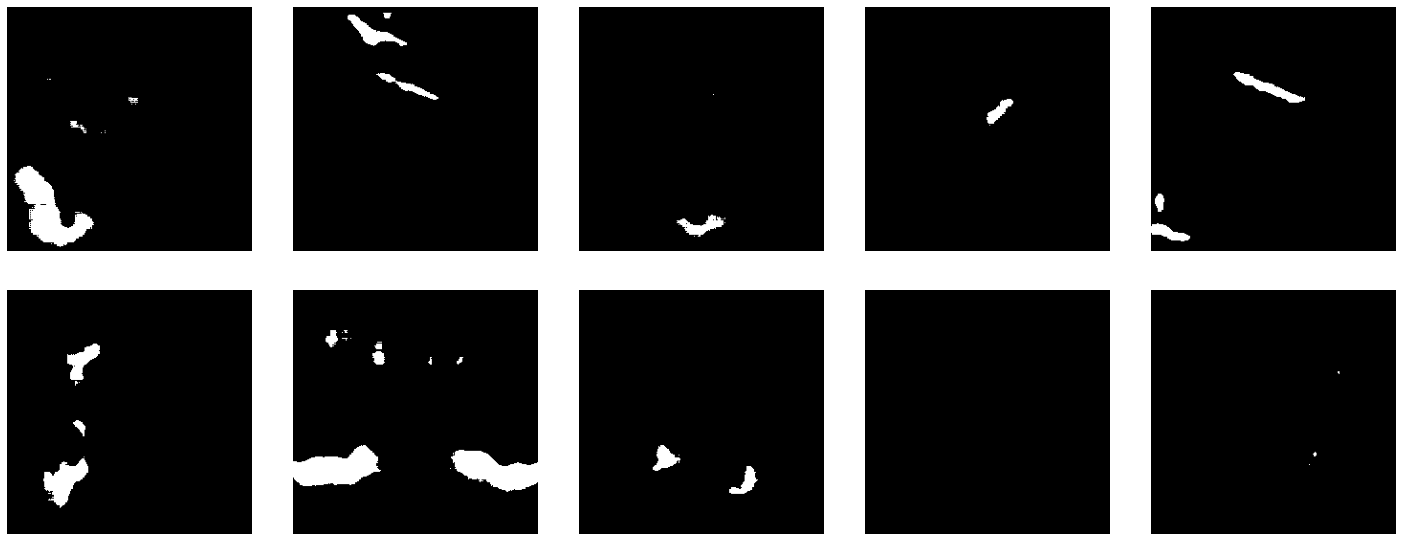

In [160]:
# Path to first batch image file
# shadow mask folder
mask_path_train = 'DESOBA_DATASET/Mfs_train'


# Get a list of all image file names in the folder
image_files = os.listdir(mask_path_train)

# Display the first 10 images
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
fig.tight_layout()

for i, image_file in enumerate(image_files[:10]):
    # Open the image using PIL
    image_path = os.path.join(mask_path_train, image_file)
    image = Image.open(image_path)
    # Display the image
    axs[i // 5, i % 5].imshow(image, cmap='gray')
    axs[i // 5, i % 5].axis('off')

plt.show()